In [8]:

from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms

In [9]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

In [10]:
def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy_with_logits(output, target.float(), size_average=False).item() # sum up batch loss
            pred = output >= 0.5 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [11]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(1, 16,  kernel_size=3) , 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=3), 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.fc = nn.Linear(32*4*4, 1)
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)
        x = x.view(-1, 32*4*4)
        x = self.fc(x)
        return x

In [12]:
def resNet18():
    resNet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    resNet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet18.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return resNet18

def resNet34():
    resNet34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False)
    resNet34.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet34.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return resNet34

def resNet50():
    resNet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
    resNet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet50.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    return resNet50

def resNet101():
    resNet101 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=False)
    resNet101.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet101.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    return resNet101

def resNet152():
    resNet152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=False)
    resNet152.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet152.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    return resNet152

In [13]:
resNets = [resNet18, resNet34, resNet50, resNet101, resNet152]

In [17]:
%%time
from random import randint

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'

download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
      ])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='train', transform=data_transform, download=download)

loss18_val = []
loss34_val = []
loss50_val = []
loss101_val = []
loss152_val = []
accs_val = []
seed = randint(0,50)

for resNet in resNets:
    if resNet is resNet18:
        print("ResNet18: ")
    elif resNet is resNet34:
        print("ResNet34: ")
    elif resNet is resNet50:
        print("ResNet50: ")
    elif resNet is resNet101:
        print("ResNet101: ")
    elif resNet is resNet152:
        print("ResNet152: ")
    # for seed in  range(0, 50):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    train_top = 10//n_classes
    val_top = 1000//n_classes
    indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
    indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

    train_data = Subset(train_dataset, indx_train)
    val_data = Subset(val_dataset, indx_val)

    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

    train_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=32, 
                                                shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_data,
                                                batch_size=128, 
                                                shuffle=False)

    model = resNet()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

    for epoch in range(50):
        l = train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
        if resNet is resNet18:
            loss18_val.append(l)
        elif resNet is resNet34:
            loss34_val.append(l)
        elif resNet is resNet50:
            loss50_val.append(l)
        elif resNet is resNet101:
            loss101_val.append(l)
        elif resNet is resNet152:
            loss152_val.append(l)

    accs_val.append(test(model, device, val_loader))

Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
ResNet18: 
Num Samples For Training 10 Num Samples For Val 1000


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\kesha/.cache\torch\hub\v0.10.0.zip
c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 0 [0/10 (0%)]	Loss: 0.879212
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000396
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000178
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000088
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000055
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000044
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000038
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000032
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000029
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000026


c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 1.8113, Accuracy: 705/1000 (70.50%)

ResNet34: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.850188
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000343
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000104
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000033
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000021
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000016
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000014
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000012
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000012
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000011

Val set: Average loss: 3.0758, Accuracy: 576/1000 (57.60%)

ResNet50: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.577791
Train Epoch: 5 [0/10 (0%)]	Loss: 0.000205
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000018
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000109
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000014
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000026
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000005
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000003
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000002
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000002

Val set: Average loss: 6.0038, Accuracy: 639/1000 (63.90%)

ResNet101: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.728613
Train Epoch: 5 [0/10 (0%)]	Loss: 0.016871
Train Epoch: 10 [0/10 (0%)]	Loss: 0.000052
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000071
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000008
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000004
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000001
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000001
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000000
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000000

Val set: Average loss: 2.2475, Accuracy: 615/1000 (61.50%)

ResNet152: 
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.882017
Train Epoch: 5 [0/10 (0%)]	Loss: 0.118311
Train Epoch: 10 [0/10 (0%)]	Loss: 0.001161
Train Epoch: 15 [0/10 (0%)]	Loss: 0.000085
Train Epoch: 20 [0/10 (0%)]	Loss: 0.000011
Train Epoch: 25 [0/10 (0%)]	Loss: 0.000016
Train Epoch: 30 [0/10 (0%)]	Loss: 0.000005
Train Epoch: 35 [0/10 (0%)]	Loss: 0.000002
Train Epoch: 40 [0/10 (0%)]	Loss: 0.000002
Train Epoch: 45 [0/10 (0%)]	Loss: 0.000003

Val set: Average loss: 4.4329, Accuracy: 602/1000 (60.20%)

CPU times: total: 8min 39s
Wall time: 4min 13s


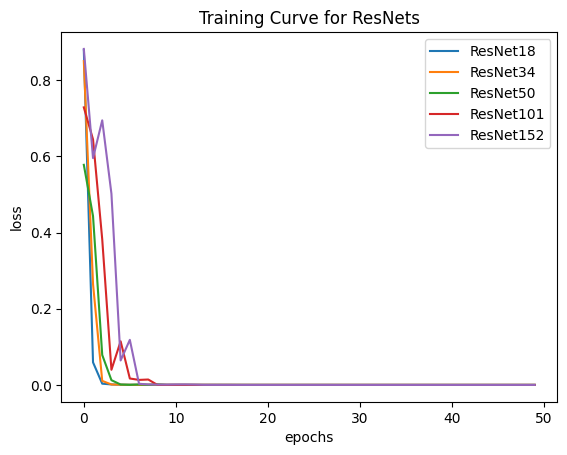

In [18]:
import matplotlib.pyplot as plt

plt.plot(loss18_val, label="ResNet18")
plt.plot(loss34_val, label="ResNet34")
plt.plot(loss50_val, label="ResNet50")
plt.plot(loss101_val, label="ResNet101")
plt.plot(loss152_val, label="ResNet152")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training Curve for ResNets');
plt.savefig('untrainedresnets_training.png')